In [173]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import optuna
import gpytorch


In [178]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 0.001861373015328207), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [3]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [4]:

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [177]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])
    lengthscale = trial.suggest_float("lengthscale", 1e-3, 1e1, log=True)

    num_tasks = 3
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)

    class TrialMultitaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, num_tasks):
            super(TrialMultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.MultitaskMean(
                gpytorch.means.ZeroMean(), num_tasks=num_tasks
            )
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale), num_tasks=num_tasks, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    model = TrialMultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    model.to(device)

    # Configure optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9, maximize=True)

    # Configure scheduler
    if scheduler_type == "ReduceLROnPlateau":
        factor = trial.suggest_float("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 3, 20)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    elif scheduler_type == "StepLR":
        step_size = trial.suggest_int("step_size", 5, 50)
        gamma = trial.suggest_float("gamma", 0.1, 0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        t_max = trial.suggest_int("t_max", 5, 50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train)
    while initial_likelihood < -1.55:
        model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
        model.to(device)
        initial_likelihood = mll(model(X_train), y_train)
    print(f'Model finially intialized with likelihood: {initial_likelihood}')

    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500  # You could also make this a hyperparameter

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train)
        loss.backward()
        optimizer.step()

        # Handle different scheduler types
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(mll(output, y_train))  # Pass validation metric
        else:
            scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate mean R² across all targets
    r2_values = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(num_tasks)]
    mean_r2 = np.mean(r2_values)

    return mean_r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-02 11:32:14,338] A new study created in memory with name: no-name-80aa4287-e754-46b5-9ec8-5c56d662ff9c


Model finially intialized with likelihood: -1.543339729309082


[I 2025-07-02 11:34:12,239] Trial 0 finished with value: 0.20700750748316446 and parameters: {'lr': 0.00016636288517048414, 'weight_decay': 3.294463022938289e-05, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 1.361649369647628, 't_max': 13}. Best is trial 0 with value: 0.20700750748316446.


Model finially intialized with likelihood: -1.4921684265136719


[I 2025-07-02 11:36:19,182] Trial 1 finished with value: 0.29752270380655926 and parameters: {'lr': 0.014146624333141972, 'weight_decay': 1.3500748062821925e-05, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 1.560283913896108, 't_max': 38}. Best is trial 1 with value: 0.29752270380655926.


Model finially intialized with likelihood: -1.5355587005615234


[I 2025-07-02 11:38:19,048] Trial 2 finished with value: 0.2727932929992676 and parameters: {'lr': 0.0928348613875169, 'weight_decay': 4.4719075643193034e-05, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 0.07868148542905666, 't_max': 40}. Best is trial 1 with value: 0.29752270380655926.


Model finially intialized with likelihood: -1.5208996534347534


[I 2025-07-02 11:40:20,229] Trial 3 finished with value: 0.1763184666633606 and parameters: {'lr': 0.00022909799100680452, 'weight_decay': 0.00022289177316649694, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 0.043253763848559265, 't_max': 34}. Best is trial 1 with value: 0.29752270380655926.


Model finially intialized with likelihood: -1.4908984899520874


[I 2025-07-02 11:43:25,202] Trial 4 finished with value: 0.25125883022944134 and parameters: {'lr': 0.00013252800291029893, 'weight_decay': 0.00029174857883073143, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.0013865178389844018, 'factor': 0.10900765554058776, 'patience': 6}. Best is trial 1 with value: 0.29752270380655926.


Model finially intialized with likelihood: -1.3802204132080078


[I 2025-07-02 11:43:25,592] Trial 5 pruned. 


Model finially intialized with likelihood: -1.415816068649292


[I 2025-07-02 11:43:26,085] Trial 6 pruned. 


Model finially intialized with likelihood: -1.4770523309707642


[I 2025-07-02 11:43:26,746] Trial 7 pruned. 


Model finially intialized with likelihood: -1.5439810752868652


[I 2025-07-02 11:46:31,310] Trial 8 finished with value: 0.43424053986867267 and parameters: {'lr': 0.010873204579394679, 'weight_decay': 0.0009152256293915124, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.001861373015328207, 'factor': 0.264146097094465, 'patience': 14}. Best is trial 8 with value: 0.43424053986867267.


Model finially intialized with likelihood: -1.488600254058838


[I 2025-07-02 11:46:31,793] Trial 9 pruned. 


Model finially intialized with likelihood: -1.5440901517868042


[I 2025-07-02 11:49:30,776] Trial 10 finished with value: 0.352569580078125 and parameters: {'lr': 0.0011690465038687813, 'weight_decay': 0.0006950150127683226, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.010319015500906628, 'factor': 0.801995663924417, 'patience': 20}. Best is trial 8 with value: 0.43424053986867267.


Model finially intialized with likelihood: -1.386722207069397


[I 2025-07-02 11:49:31,290] Trial 11 pruned. 


Model finially intialized with likelihood: -1.5331101417541504


[I 2025-07-02 11:49:32,269] Trial 12 pruned. 


Model finially intialized with likelihood: -1.5218490362167358


[I 2025-07-02 11:49:32,811] Trial 13 pruned. 


Model finially intialized with likelihood: -1.5395140647888184


[I 2025-07-02 11:52:27,563] Trial 14 finished with value: 0.24519660075505575 and parameters: {'lr': 0.0007256945800097594, 'weight_decay': 0.0004900954798084838, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.017791170992408418, 'factor': 0.6840382708752697, 'patience': 14}. Best is trial 8 with value: 0.43424053986867267.


Model finially intialized with likelihood: -1.5237326622009277


[I 2025-07-02 11:52:28,065] Trial 15 pruned. 


Model finially intialized with likelihood: -1.3449162244796753


[I 2025-07-02 11:52:28,550] Trial 16 pruned. 
[W 2025-07-02 12:25:15,093] Trial 17 failed with parameters: {'lr': 0.0019772434499958674, 'weight_decay': 0.00043291367234883995, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.028393764535500857, 'factor': 0.6127192108328837, 'patience': 10} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_26204\989518133.py", line 61, in objective
    initial_likelihood = mll(model(X_train), y_train)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\module.py", line 82, in __call__
    outputs = self.forward(*inputs, **kwargs)
              

KeyboardInterrupt: 

In [182]:
device = 'cuda'
torch.manual_seed(42)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 3
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
# likelihood.noise = 0.5
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
model.to(device)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.55:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    model.to(device)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.02, weight_decay = 1e-5, maximize=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.010873204579394679, weight_decay = 0.0009152256293915124, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600], gamma=10)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold=1e-4)
# scheduler = IncreaseLROnPlateau(optimizer, mode='max', patience=3, threshold=1e-4, factor=2.0, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.264146097094465, patience=14, threshold=1e-4)

training_loss = []
test_losses = []


Model finially intialized with likelihood: -1.4998235702514648


In [188]:
num_iter = 500
model.to(device)
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    mean = output.mean
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())

    # Break the loop if loss does not decrease significantly over the last 3 epochs
    if i > 3 and abs(training_loss[-1] - training_loss[-2]) < 1e-5 and abs(training_loss[-2] - training_loss[-3]) < 1e-5:
        print(f"Early stopping at iteration {i} with loss {loss.item()}")
        break

    optimizer.step()
    scheduler.step(loss.item())

    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())

    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -0.539
Iter 2/500 - Loss: -0.538
Iter 3/500 - Loss: -0.538
Iter 4/500 - Loss: -0.538
Iter 5/500 - Loss: -0.538
Iter 6/500 - Loss: -0.538
Iter 7/500 - Loss: -0.538
Iter 8/500 - Loss: -0.538
Iter 9/500 - Loss: -0.538
Iter 10/500 - Loss: -0.537
Iter 11/500 - Loss: -0.537
Iter 12/500 - Loss: -0.537
Iter 13/500 - Loss: -0.537
Iter 14/500 - Loss: -0.537
Iter 15/500 - Loss: -0.537
Iter 16/500 - Loss: -0.537
Iter 17/500 - Loss: -0.537
Iter 18/500 - Loss: -0.537
Iter 19/500 - Loss: -0.537
Iter 20/500 - Loss: -0.536
Iter 21/500 - Loss: -0.536
Iter 22/500 - Loss: -0.536
Iter 23/500 - Loss: -0.536
Iter 24/500 - Loss: -0.536
Iter 25/500 - Loss: -0.536
Iter 26/500 - Loss: -0.536
Iter 27/500 - Loss: -0.536
Iter 28/500 - Loss: -0.536
Iter 29/500 - Loss: -0.536
Iter 30/500 - Loss: -0.536
Iter 31/500 - Loss: -0.536
Iter 32/500 - Loss: -0.535
Iter 33/500 - Loss: -0.535
Iter 34/500 - Loss: -0.535
Iter 35/500 - Loss: -0.535
Iter 36/500 - Loss: -0.535
Iter 37/500 - Loss: -0.535
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

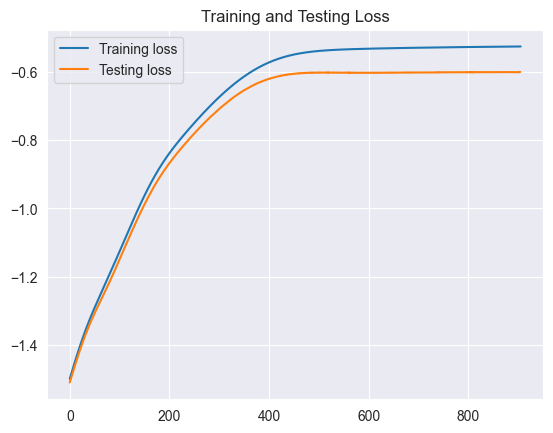

In [189]:
plt.title('Training and Testing Loss')
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [190]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')

Parameter name: likelihood.task_noise_covar_factor         value = [[-0.32023391127586365], [-0.480086088180542], [-0.5543707609176636]]
Parameter name: likelihood.raw_noise                       value = [-5.26782751083374]
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.020225608721375465], [-1.2306606769561768], [-1.2026329040527344]]
Parameter name: covar_module.task_covar_module.raw_var     value = [1.0821231603622437, -4.819698810577393, -3.9354207515716553]
Parameter name: covar_module.data_covar_module.raw_lengthscale value = [[4.722111701965332]]
Parameter name: covar_module.data_covar_module.raw_alpha   value = [-2.6294054985046387]


In [191]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Target 1: MSE = 0.0636, RMSE = 0.2523, R2 = 0.9350
Target 2: MSE = 0.1336, RMSE = 0.3655, R2 = 0.8632
Target 3: MSE = 0.2002, RMSE = 0.4474, R2 = 0.7930


Target 1: MSE = 0.4080, RMSE = 0.6387, R2 = 0.6227
Target 2: MSE = 0.6822, RMSE = 0.8260, R2 = 0.3763
Target 3: MSE = 0.7890, RMSE = 0.8883, R2 = 0.3029


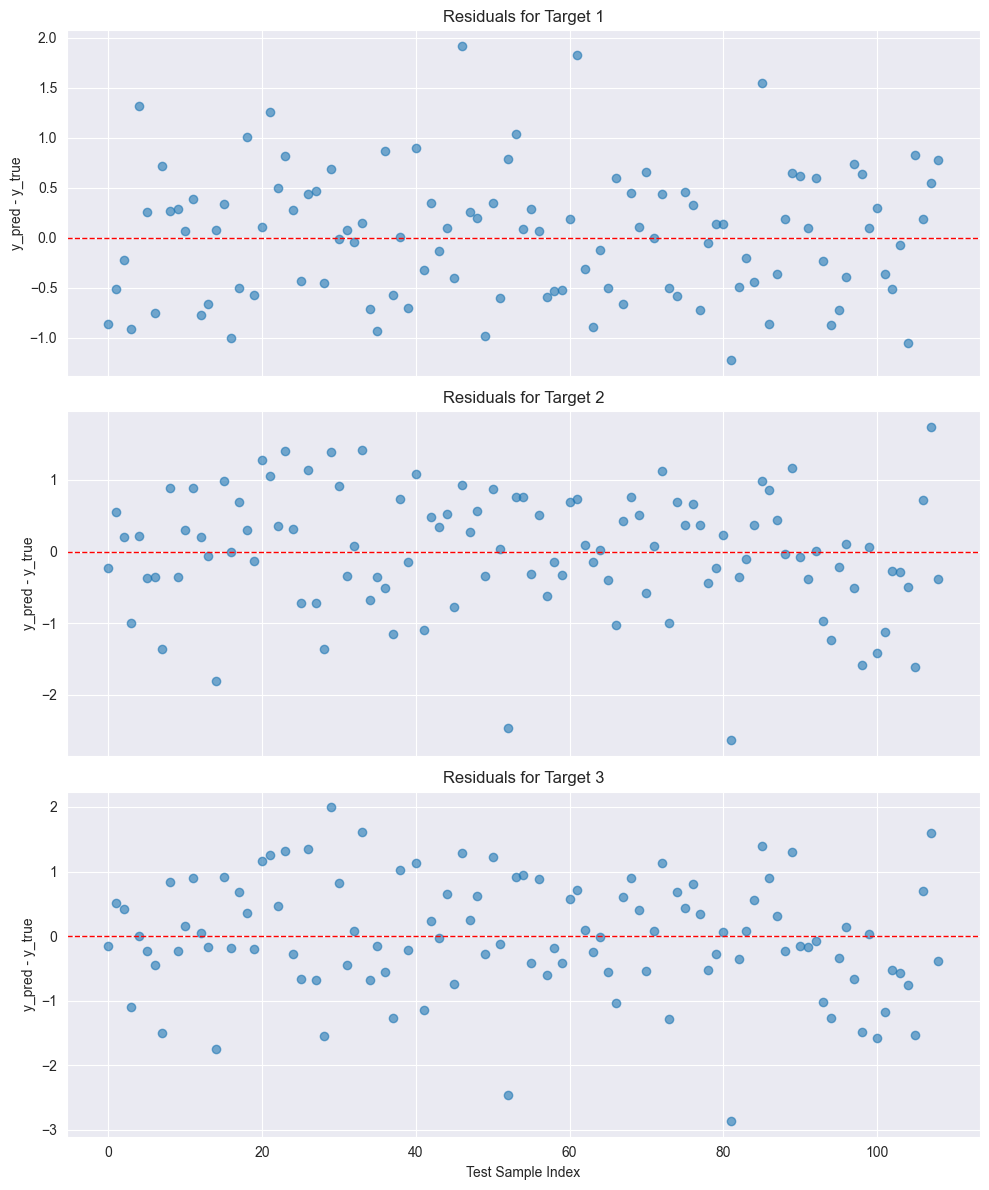

In [192]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

# y_true_np = y_test.cpu().numpy()
# y_pred_np = mean.cpu().numpy()
#
# num_targets = y_true_np.shape[1]

# Plot residuals for each target
fig, axs = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

for i in range(num_targets):
    residuals = y_pred_np[:, i] - y_true_np[:, i]

    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axs[i].set_title(f"Residuals for Target {i+1}")
    axs[i].set_ylabel("y_pred - y_true")
    axs[i].grid(True)

plt.xlabel("Test Sample Index")
plt.tight_layout()
plt.show()

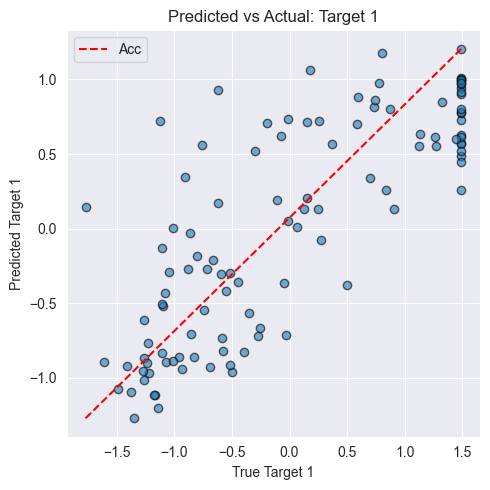

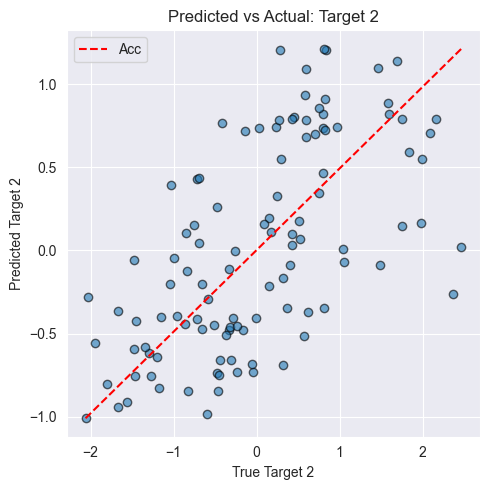

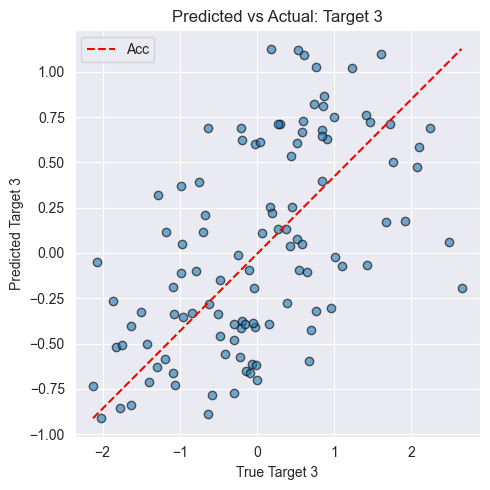

In [168]:
for i in range(y_test.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i].cpu().numpy(), mean[:, i].cpu().numpy(), alpha=0.6, edgecolors='k')
    plt.plot([y_test.cpu().numpy()[:, i].min(), y_test.cpu().numpy()[:, i].max()],
             [y_pred_np[:, i].min(), y_pred_np[:, i].max()], 'r--', label='Acc')

    plt.xlabel(f"True Target {i+1}")
    plt.ylabel(f"Predicted Target {i+1}")
    plt.title(f"Predicted vs Actual: Target {i+1}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STL
## PTAU


In [288]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(alpha = 0.01, lengthscale = 0.02673124755002312), outputscale=1.8842189942421166, num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [319]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 1) (109, 1)


In [320]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

In [325]:
def objective(trial):
    # Define hyperparameter search space
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    weight_decay = 1e-4
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    # scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])

    # Model parameters
    lengthscale = trial.suggest_float("lengthscale", 1e-3, 1e1, log=True)
    outputscale = trial.suggest_float("outputscale", 0.1, 10.0, log=True)

    # Initialize likelihood for single task
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)

    # Single task GP model
    class SingleTaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(SingleTaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale),
                outputscale=outputscale
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Reshape y_train for single task (squeeze to remove extra dimension)
    y_train_single = y_train.squeeze(-1)
    y_test_single = y_test.squeeze(-1)

    # Initialize model
    model = SingleTaskGPModel(X_train, y_train_single, likelihood)
    model.to(device)

    # Configure optimizer
    # if optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    # else:
    #     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)

    # Configure scheduler
    # if scheduler_type == "ReduceLROnPlateau":
    #     factor = trial.suggest_float("factor", 0.1, 0.9)
    #     patience = trial.suggest_int("patience", 3, 20)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #         optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    # else:
    #     t_max = trial.suggest_int("t_max", 5, 50)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train_single)
    # while initial_likelihood < -3:
    #     model = SingleTaskGPModel(X_train, y_train_single, likelihood)
    #     model.to(device)
    #     initial_likelihood = mll(model(X_train), y_train_single)
    print(f'Model finally initialized with likelihood: {initial_likelihood}')


    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train_single)
        loss.backward()
        optimizer.step()

        # # Handle different scheduler types
        # if scheduler_type == "ReduceLROnPlateau":
        #     scheduler.step(loss.item())  # Pass validation metric
        # else:
        #     scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test_single.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate R² for single target
    r2 = r2_score(y_true_np, y_pred_np)

    return r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-02 15:53:02,691] A new study created in memory with name: no-name-6e3ef58c-9230-4458-8bf7-23b7005911d4


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:12,333] Trial 0 finished with value: 0.29842013120651245 and parameters: {'lr': 0.03248555619696034, 'optimizer': 'AdamW', 'lengthscale': 0.07211758187155022, 'outputscale': 7.94573563496377}. Best is trial 0 with value: 0.29842013120651245.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:16,299] Trial 1 finished with value: 0.2867239713668823 and parameters: {'lr': 0.014543960936816529, 'optimizer': 'AdamW', 'lengthscale': 0.07431975811189531, 'outputscale': 0.27507796908096216}. Best is trial 0 with value: 0.29842013120651245.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:20,103] Trial 2 finished with value: 0.18705397844314575 and parameters: {'lr': 0.005613209453388544, 'optimizer': 'AdamW', 'lengthscale': 5.384268043970572, 'outputscale': 1.1676327279420253}. Best is trial 0 with value: 0.29842013120651245.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:24,038] Trial 3 finished with value: 0.18473070859909058 and parameters: {'lr': 0.005550837530429694, 'optimizer': 'AdamW', 'lengthscale': 5.356964678289404, 'outputscale': 0.3291604789750373}. Best is trial 0 with value: 0.29842013120651245.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:27,904] Trial 4 finished with value: 0.30076223611831665 and parameters: {'lr': 0.06638256963342112, 'optimizer': 'AdamW', 'lengthscale': 0.17345215098890104, 'outputscale': 4.2709279894030265}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:31,744] Trial 5 finished with value: -0.8590043783187866 and parameters: {'lr': 0.0011751073615840232, 'optimizer': 'AdamW', 'lengthscale': 0.891200810296726, 'outputscale': 4.452265373096485}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:35,983] Trial 6 finished with value: 0.11454463005065918 and parameters: {'lr': 0.00420589364088297, 'optimizer': 'AdamW', 'lengthscale': 0.8695593997981853, 'outputscale': 0.1945102749101485}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:41,209] Trial 7 finished with value: -1.922558069229126 and parameters: {'lr': 0.0006799026995400676, 'optimizer': 'AdamW', 'lengthscale': 1.9971017046605801, 'outputscale': 1.6724581612853164}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:45,494] Trial 8 finished with value: -2.771042585372925 and parameters: {'lr': 0.0004887411197409248, 'optimizer': 'AdamW', 'lengthscale': 0.06257035322572228, 'outputscale': 0.10197370215085948}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:49,907] Trial 9 finished with value: 0.2971721291542053 and parameters: {'lr': 0.027129193541987725, 'optimizer': 'AdamW', 'lengthscale': 0.002881867732539957, 'outputscale': 5.95640695920088}. Best is trial 4 with value: 0.30076223611831665.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:54,458] Trial 10 finished with value: 0.30129218101501465 and parameters: {'lr': 0.09773055015818621, 'optimizer': 'AdamW', 'lengthscale': 0.0034478329769432547, 'outputscale': 2.5198008092057593}. Best is trial 10 with value: 0.30129218101501465.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:53:58,783] Trial 11 finished with value: 0.30107641220092773 and parameters: {'lr': 0.0815100404522597, 'optimizer': 'AdamW', 'lengthscale': 0.0014359974887067192, 'outputscale': 2.747520245543272}. Best is trial 10 with value: 0.30129218101501465.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:03,068] Trial 12 finished with value: 0.30131274461746216 and parameters: {'lr': 0.0983332547706604, 'optimizer': 'AdamW', 'lengthscale': 0.0010108833278108028, 'outputscale': 2.4276975150268543}. Best is trial 12 with value: 0.30131274461746216.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:07,191] Trial 13 finished with value: -6.176451206207275 and parameters: {'lr': 0.00010636279743851572, 'optimizer': 'AdamW', 'lengthscale': 0.006991091470378016, 'outputscale': 0.5779801017123049}. Best is trial 12 with value: 0.30131274461746216.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:11,700] Trial 14 finished with value: 0.28907835483551025 and parameters: {'lr': 0.015793662966970747, 'optimizer': 'AdamW', 'lengthscale': 0.00978424921855356, 'outputscale': 2.0297106840697827}. Best is trial 12 with value: 0.30131274461746216.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:16,014] Trial 15 finished with value: 0.3013305068016052 and parameters: {'lr': 0.0998899719469771, 'optimizer': 'AdamW', 'lengthscale': 0.0010373643542970269, 'outputscale': 0.5773225190490089}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:20,058] Trial 16 finished with value: 0.29895681142807007 and parameters: {'lr': 0.035933882782178225, 'optimizer': 'AdamW', 'lengthscale': 0.0010294034822630387, 'outputscale': 0.6882169297700295}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:24,315] Trial 17 finished with value: 0.2770847678184509 and parameters: {'lr': 0.011613496769454765, 'optimizer': 'AdamW', 'lengthscale': 0.019778397110416637, 'outputscale': 0.8869474235195486}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:28,349] Trial 18 finished with value: 0.30007028579711914 and parameters: {'lr': 0.04840985658055388, 'optimizer': 'AdamW', 'lengthscale': 0.013408354434047825, 'outputscale': 0.4582542037643069}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:32,485] Trial 19 finished with value: -0.3391803503036499 and parameters: {'lr': 0.001829999969132854, 'optimizer': 'AdamW', 'lengthscale': 0.0030000456144286492, 'outputscale': 1.2037453660457103}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:36,939] Trial 20 finished with value: -5.870611667633057 and parameters: {'lr': 0.00012949557858858352, 'optimizer': 'AdamW', 'lengthscale': 0.029353390540299822, 'outputscale': 0.17673446426982364}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:41,467] Trial 21 finished with value: 0.30117255449295044 and parameters: {'lr': 0.08796000537689674, 'optimizer': 'AdamW', 'lengthscale': 0.0034510269484823958, 'outputscale': 2.499027169695904}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:46,231] Trial 22 finished with value: 0.3012860417366028 and parameters: {'lr': 0.0966183040119766, 'optimizer': 'AdamW', 'lengthscale': 0.0011039705998514284, 'outputscale': 3.3264531877094803}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:50,203] Trial 23 finished with value: 0.2955021262168884 and parameters: {'lr': 0.022841197244121245, 'optimizer': 'AdamW', 'lengthscale': 0.005043998319192385, 'outputscale': 1.9252972419817913}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:54,545] Trial 24 finished with value: 0.29998892545700073 and parameters: {'lr': 0.04703787802937236, 'optimizer': 'AdamW', 'lengthscale': 0.002290676886273546, 'outputscale': 1.2216156143489816}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:54:59,276] Trial 25 finished with value: 0.26177722215652466 and parameters: {'lr': 0.00941040828210638, 'optimizer': 'AdamW', 'lengthscale': 0.0019066607081826153, 'outputscale': 0.7615023718614432}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:04,250] Trial 26 finished with value: 0.30052685737609863 and parameters: {'lr': 0.05852282697512162, 'optimizer': 'AdamW', 'lengthscale': 0.008120180230979077, 'outputscale': 9.163866490156643}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:08,770] Trial 27 finished with value: 0.2948961853981018 and parameters: {'lr': 0.02172019052958074, 'optimizer': 'AdamW', 'lengthscale': 0.24331968343138352, 'outputscale': 1.6025094124160222}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:13,000] Trial 28 finished with value: 0.30127519369125366 and parameters: {'lr': 0.09585580068899491, 'optimizer': 'AdamW', 'lengthscale': 0.005163924083914205, 'outputscale': 0.42369487034903924}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:17,837] Trial 29 finished with value: 0.29894739389419556 and parameters: {'lr': 0.03587095320808248, 'optimizer': 'AdamW', 'lengthscale': 0.03454923817230723, 'outputscale': 4.264299177560931}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:22,486] Trial 30 finished with value: 0.2999368906021118 and parameters: {'lr': 0.046232549287562395, 'optimizer': 'AdamW', 'lengthscale': 0.0010425524991079123, 'outputscale': 3.3813256600363237}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:26,670] Trial 31 finished with value: 0.3011399507522583 and parameters: {'lr': 0.08583660604633112, 'optimizer': 'AdamW', 'lengthscale': 0.001595558639782695, 'outputscale': 6.155692637565765}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:31,596] Trial 32 finished with value: 0.3013262152671814 and parameters: {'lr': 0.0995305872115118, 'optimizer': 'AdamW', 'lengthscale': 0.0010830986188965263, 'outputscale': 3.1670232519430837}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:42,566] Trial 33 finished with value: 0.3004595637321472 and parameters: {'lr': 0.056681901694208184, 'optimizer': 'AdamW', 'lengthscale': 0.003937709893295148, 'outputscale': 6.335310409029342}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:55:54,175] Trial 34 finished with value: 0.2984083294868469 and parameters: {'lr': 0.03241281914871429, 'optimizer': 'AdamW', 'lengthscale': 0.002826488401895337, 'outputscale': 2.3765525966889114}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:07,093] Trial 35 finished with value: 0.2935716509819031 and parameters: {'lr': 0.019763322030845666, 'optimizer': 'AdamW', 'lengthscale': 0.002016035057353016, 'outputscale': 1.4419083296086626}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:20,331] Trial 36 finished with value: 0.2550457715988159 and parameters: {'lr': 0.008780441697255309, 'optimizer': 'AdamW', 'lengthscale': 0.0137082104482451, 'outputscale': 3.5520274068133775}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:31,598] Trial 37 finished with value: 0.3006333112716675 and parameters: {'lr': 0.061739839289385624, 'optimizer': 'AdamW', 'lengthscale': 0.0015702233560447002, 'outputscale': 0.3298224931843228}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:39,581] Trial 38 finished with value: 0.29922837018966675 and parameters: {'lr': 0.03813415199234759, 'optimizer': 'AdamW', 'lengthscale': 0.18073656440731448, 'outputscale': 1.0969224834275655}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:43,655] Trial 39 finished with value: 0.3007662296295166 and parameters: {'lr': 0.06635993301125451, 'optimizer': 'AdamW', 'lengthscale': 0.006249489381413107, 'outputscale': 5.327811099274036}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:47,674] Trial 40 finished with value: -0.10013115406036377 and parameters: {'lr': 0.0025430691141480654, 'optimizer': 'AdamW', 'lengthscale': 0.3489423804888743, 'outputscale': 8.076188133091764}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:51,788] Trial 41 finished with value: 0.30109500885009766 and parameters: {'lr': 0.08266621139662557, 'optimizer': 'AdamW', 'lengthscale': 0.001024503892476896, 'outputscale': 2.9470923634066737}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:56:56,046] Trial 42 finished with value: 0.30116891860961914 and parameters: {'lr': 0.08778086356049403, 'optimizer': 'AdamW', 'lengthscale': 0.0010069357059493702, 'outputscale': 3.7757859408881913}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:00,473] Trial 43 finished with value: 0.3012862801551819 and parameters: {'lr': 0.09674691119477405, 'optimizer': 'AdamW', 'lengthscale': 0.0017410050255186498, 'outputscale': 1.8686787131384923}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:04,941] Trial 44 finished with value: 0.30059778690338135 and parameters: {'lr': 0.060479049071246384, 'optimizer': 'AdamW', 'lengthscale': 0.002124554262011671, 'outputscale': 2.0257661969581613}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:09,998] Trial 45 finished with value: -4.0737409591674805 and parameters: {'lr': 0.000301167279743786, 'optimizer': 'AdamW', 'lengthscale': 0.003949120343448915, 'outputscale': 1.4150112318932795}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:14,115] Trial 46 finished with value: 0.2995986342430115 and parameters: {'lr': 0.041852127527115805, 'optimizer': 'AdamW', 'lengthscale': 0.0015970594591156973, 'outputscale': 0.8873890249909169}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:18,329] Trial 47 finished with value: 0.2972153425216675 and parameters: {'lr': 0.02727520098511382, 'optimizer': 'AdamW', 'lengthscale': 7.613393627646798, 'outputscale': 2.218116041996521}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:22,630] Trial 48 finished with value: 0.19602501392364502 and parameters: {'lr': 0.005870487675665288, 'optimizer': 'AdamW', 'lengthscale': 0.08219293264050026, 'outputscale': 1.7355795219482937}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:26,846] Trial 49 finished with value: 0.30087244510650635 and parameters: {'lr': 0.07084018229409644, 'optimizer': 'AdamW', 'lengthscale': 0.010729110953967764, 'outputscale': 4.7457277121237444}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:31,459] Trial 50 finished with value: 0.2896343469619751 and parameters: {'lr': 0.016148159113542768, 'optimizer': 'AdamW', 'lengthscale': 3.236679272011824, 'outputscale': 2.592749515464391}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:35,882] Trial 51 finished with value: 0.3012431859970093 and parameters: {'lr': 0.09315874537485527, 'optimizer': 'AdamW', 'lengthscale': 0.00145984221330681, 'outputscale': 3.141632995612849}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:40,221] Trial 52 finished with value: 0.3013261556625366 and parameters: {'lr': 0.09980165183644985, 'optimizer': 'AdamW', 'lengthscale': 0.002558282540471238, 'outputscale': 0.5482760329340338}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:44,427] Trial 53 finished with value: 0.3008098602294922 and parameters: {'lr': 0.06815921917451119, 'optimizer': 'AdamW', 'lengthscale': 0.0027012622765901924, 'outputscale': 0.6195558453599626}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:49,121] Trial 54 finished with value: 0.3002581000328064 and parameters: {'lr': 0.05193380733569821, 'optimizer': 'AdamW', 'lengthscale': 0.004281180132849994, 'outputscale': 0.4652288302829741}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:53,806] Trial 55 finished with value: 0.3008711338043213 and parameters: {'lr': 0.07082970570071305, 'optimizer': 'AdamW', 'lengthscale': 0.0025361738296773664, 'outputscale': 0.9381146999224537}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:57:57,949] Trial 56 finished with value: 0.2974381446838379 and parameters: {'lr': 0.028057431158901032, 'optimizer': 'AdamW', 'lengthscale': 0.0013771825050813812, 'outputscale': 0.24916762019212366}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:02,299] Trial 57 finished with value: 0.2999149560928345 and parameters: {'lr': 0.04591072766744023, 'optimizer': 'AdamW', 'lengthscale': 0.6828543403356142, 'outputscale': 0.7882615375976632}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:06,632] Trial 58 finished with value: -0.6510540246963501 and parameters: {'lr': 0.0013667244004986032, 'optimizer': 'AdamW', 'lengthscale': 0.006486571015055066, 'outputscale': 0.5081398803556362}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:13,086] Trial 59 finished with value: 0.298488974571228 and parameters: {'lr': 0.032875660395428094, 'optimizer': 'AdamW', 'lengthscale': 0.0032571204561824846, 'outputscale': 1.3869572922603046}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:22,939] Trial 60 finished with value: 0.3012680411338806 and parameters: {'lr': 0.09544077751597081, 'optimizer': 'AdamW', 'lengthscale': 0.0018532285876935524, 'outputscale': 0.32802859427387726}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:31,783] Trial 61 finished with value: 0.30131858587265015 and parameters: {'lr': 0.09953385924920388, 'optimizer': 'AdamW', 'lengthscale': 0.0011909784926266316, 'outputscale': 2.7642741853355663}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:40,686] Trial 62 finished with value: 0.3009323477745056 and parameters: {'lr': 0.07361100004829611, 'optimizer': 'AdamW', 'lengthscale': 0.0013133024502353205, 'outputscale': 4.1348436345585355}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:49,548] Trial 63 finished with value: 0.3003881573677063 and parameters: {'lr': 0.054883875210124375, 'optimizer': 'AdamW', 'lengthscale': 0.002362418419190967, 'outputscale': 2.781189298140601}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:58:59,612] Trial 64 finished with value: 0.301292359828949 and parameters: {'lr': 0.09741890985023001, 'optimizer': 'AdamW', 'lengthscale': 0.0050831169615231245, 'outputscale': 1.8233675847466018}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:08,820] Trial 65 finished with value: 0.30132830142974854 and parameters: {'lr': 0.09980945276965963, 'optimizer': 'AdamW', 'lengthscale': 0.004912479772893493, 'outputscale': 2.265557998179158}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:18,478] Trial 66 finished with value: 0.30092018842697144 and parameters: {'lr': 0.07293437341314528, 'optimizer': 'AdamW', 'lengthscale': 0.04516214394791256, 'outputscale': 2.1528430821733204}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:27,556] Trial 67 finished with value: 0.2996167540550232 and parameters: {'lr': 0.04202239252380871, 'optimizer': 'AdamW', 'lengthscale': 0.004525334958135058, 'outputscale': 0.5925785593303771}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:31,925] Trial 68 finished with value: 0.3003188371658325 and parameters: {'lr': 0.05329328741144011, 'optimizer': 'AdamW', 'lengthscale': 0.01731703070975622, 'outputscale': 0.3952680337287654}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:36,470] Trial 69 finished with value: 0.3008596897125244 and parameters: {'lr': 0.07012058043041047, 'optimizer': 'AdamW', 'lengthscale': 0.008658376137830302, 'outputscale': 0.12557283563251156}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:40,833] Trial 70 finished with value: 0.3003581166267395 and parameters: {'lr': 0.054129289769235166, 'optimizer': 'AdamW', 'lengthscale': 0.005969642738883826, 'outputscale': 1.082538843936492}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:44,999] Trial 71 finished with value: 0.30107003450393677 and parameters: {'lr': 0.08135447974386, 'optimizer': 'AdamW', 'lengthscale': 0.003312402888976159, 'outputscale': 2.5460640218175774}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:49,809] Trial 72 finished with value: 0.30131810903549194 and parameters: {'lr': 0.0989765728223349, 'optimizer': 'AdamW', 'lengthscale': 0.0011956975811582699, 'outputscale': 1.6098420172635304}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:54,261] Trial 73 finished with value: 0.30131256580352783 and parameters: {'lr': 0.09911743731945029, 'optimizer': 'AdamW', 'lengthscale': 0.001288059526852956, 'outputscale': 1.2949959681207392}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 15:59:58,537] Trial 74 finished with value: 0.3013242483139038 and parameters: {'lr': 0.09987836558907444, 'optimizer': 'AdamW', 'lengthscale': 0.001275610146176914, 'outputscale': 1.5922740698423477}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:03,217] Trial 75 finished with value: 0.30100858211517334 and parameters: {'lr': 0.07761799297464979, 'optimizer': 'AdamW', 'lengthscale': 0.0012182109168372313, 'outputscale': 1.6449602828431318}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:07,699] Trial 76 finished with value: 0.2994353175163269 and parameters: {'lr': 0.04008754975224049, 'optimizer': 'AdamW', 'lengthscale': 0.00187148736160708, 'outputscale': 0.7363395357790843}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:11,952] Trial 77 finished with value: 0.3005461096763611 and parameters: {'lr': 0.05908789946431785, 'optimizer': 'AdamW', 'lengthscale': 0.0010084614615414795, 'outputscale': 2.1984824559465697}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:17,405] Trial 78 finished with value: -2.396475076675415 and parameters: {'lr': 0.0005625617175082188, 'optimizer': 'AdamW', 'lengthscale': 0.0023940594594341305, 'outputscale': 1.5347540707981702}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:21,843] Trial 79 finished with value: 0.3006775379180908 and parameters: {'lr': 0.06309152061787354, 'optimizer': 'AdamW', 'lengthscale': 0.0013696563164175694, 'outputscale': 3.025872167946381}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:26,111] Trial 80 finished with value: 0.30104005336761475 and parameters: {'lr': 0.07938275230116931, 'optimizer': 'AdamW', 'lengthscale': 0.0019398208827158118, 'outputscale': 3.865373030667165}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:31,116] Trial 81 finished with value: 0.30110079050064087 and parameters: {'lr': 0.08310075707352704, 'optimizer': 'AdamW', 'lengthscale': 0.0012537447385012207, 'outputscale': 1.4221508479335527}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:35,505] Trial 82 finished with value: 0.30123990774154663 and parameters: {'lr': 0.09268428821054618, 'optimizer': 'AdamW', 'lengthscale': 0.001579865001251922, 'outputscale': 1.2493475858978436}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:39,973] Trial 83 finished with value: 0.3013073801994324 and parameters: {'lr': 0.09842296161621321, 'optimizer': 'AdamW', 'lengthscale': 0.0012428515011176503, 'outputscale': 1.0300197349072853}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:44,336] Trial 84 finished with value: 0.30069154500961304 and parameters: {'lr': 0.06354674284502092, 'optimizer': 'AdamW', 'lengthscale': 0.002803350051189592, 'outputscale': 1.2862773235668916}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:48,853] Trial 85 finished with value: 0.3000941872596741 and parameters: {'lr': 0.04883752179585683, 'optimizer': 'AdamW', 'lengthscale': 0.0010068438821733555, 'outputscale': 2.4277741670907718}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:53,556] Trial 86 finished with value: -4.923487663269043 and parameters: {'lr': 0.00021124244106554194, 'optimizer': 'AdamW', 'lengthscale': 0.002158644084412837, 'outputscale': 1.9213903166107578}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:00:57,712] Trial 87 finished with value: 0.30107951164245605 and parameters: {'lr': 0.08167990818345935, 'optimizer': 'AdamW', 'lengthscale': 0.0034303710052551385, 'outputscale': 0.6485796306663025}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:03,448] Trial 88 finished with value: -1.288964033126831 and parameters: {'lr': 0.0009125502157563266, 'optimizer': 'AdamW', 'lengthscale': 0.0017015841917911608, 'outputscale': 0.8351349830680125}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:08,106] Trial 89 finished with value: 0.29851746559143066 and parameters: {'lr': 0.03304531463302893, 'optimizer': 'AdamW', 'lengthscale': 0.0012561181042264472, 'outputscale': 3.40700404301617}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:12,371] Trial 90 finished with value: 0.30072176456451416 and parameters: {'lr': 0.06490432386489138, 'optimizer': 'AdamW', 'lengthscale': 0.002157351112306708, 'outputscale': 2.786888021664371}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:16,860] Trial 91 finished with value: 0.3012927770614624 and parameters: {'lr': 0.09743089613315865, 'optimizer': 'AdamW', 'lengthscale': 0.0013493255592572483, 'outputscale': 1.0838842541887217}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:21,192] Trial 92 finished with value: 0.3010556697845459 and parameters: {'lr': 0.08033388658422133, 'optimizer': 'AdamW', 'lengthscale': 0.0011659738210000276, 'outputscale': 0.9981378481711839}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:25,734] Trial 93 finished with value: 0.3013036251068115 and parameters: {'lr': 0.09800912188660058, 'optimizer': 'AdamW', 'lengthscale': 0.0016026418492090114, 'outputscale': 1.6498450786920207}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:29,917] Trial 94 finished with value: 0.3013293743133545 and parameters: {'lr': 0.09987959640087912, 'optimizer': 'AdamW', 'lengthscale': 0.00257210247660163, 'outputscale': 0.5047629701443269}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:34,326] Trial 95 finished with value: 0.2999614477157593 and parameters: {'lr': 0.04662705639354229, 'optimizer': 'AdamW', 'lengthscale': 0.0028358281394055486, 'outputscale': 0.4965277775587331}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:40,360] Trial 96 finished with value: 0.30089443922042847 and parameters: {'lr': 0.07202317434710126, 'optimizer': 'AdamW', 'lengthscale': 0.12041045244861746, 'outputscale': 5.080487126785686}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:44,494] Trial 97 finished with value: 0.3004632592201233 and parameters: {'lr': 0.05681913390377595, 'optimizer': 'AdamW', 'lengthscale': 0.003953025341289969, 'outputscale': 0.5508966198346955}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:49,061] Trial 98 finished with value: 0.07238733768463135 and parameters: {'lr': 0.0036990592260359493, 'optimizer': 'AdamW', 'lengthscale': 0.0017101336313105643, 'outputscale': 0.4182642991077232}. Best is trial 15 with value: 0.3013305068016052.


Model finally initialized with likelihood: -3.815532922744751


[I 2025-07-02 16:01:53,736] Trial 99 finished with value: 0.3011382818222046 and parameters: {'lr': 0.0857822808260047, 'optimizer': 'AdamW', 'lengthscale': 0.0022067132935695505, 'outputscale': 0.35195766309773724}. Best is trial 15 with value: 0.3013305068016052.


Best trial:
  R² Score: 0.3013305068016052
  Params: 
    lr: 0.0998899719469771
    optimizer: AdamW
    lengthscale: 0.0010373643542970269
    outputscale: 0.5773225190490089


In [306]:
num_tasks = 1
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1)
# likelihood.noise = 10
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
model.to(device)
initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -2.75:
    model = MultitaskGPModel(X_train, y_train, likelihood)
    model.to(device)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finally initialized with likelihood: {initial_likelihood}')
train_losses = []

Model finally initialized with likelihood: -1.6734539270401


In [315]:
model.to(device)
model.train()
likelihood.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay = 1e-1, maximize=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.009969398049228019, weight_decay = 1e-4, maximize=True)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5639435252677821)

num_iter = 500
for i in range(num_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    train_losses.append(loss.item())

    # Break the loop if loss does not decrease significantly over the last 3 epochs
    if i > 3 and abs(train_losses[-1] - train_losses[-2]) < 1e-5 and abs(train_losses[-2] - train_losses[-3]) < 1e-5:
        print(f"Early stopping at iteration {i} with loss {loss.item()}")
        break

    loss.backward()
    optimizer.step()
    # scheduler.step(loss.item())
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -0.515
Iter 2/500 - Loss: -0.514
Iter 3/500 - Loss: -0.513
Iter 4/500 - Loss: -0.512
Iter 5/500 - Loss: -0.511
Iter 6/500 - Loss: -0.510
Iter 7/500 - Loss: -0.509
Iter 8/500 - Loss: -0.508
Iter 9/500 - Loss: -0.507
Iter 10/500 - Loss: -0.506
Iter 11/500 - Loss: -0.505
Iter 12/500 - Loss: -0.504
Iter 13/500 - Loss: -0.504
Iter 14/500 - Loss: -0.503
Iter 15/500 - Loss: -0.502
Iter 16/500 - Loss: -0.501
Iter 17/500 - Loss: -0.500
Iter 18/500 - Loss: -0.499
Iter 19/500 - Loss: -0.499
Iter 20/500 - Loss: -0.498
Iter 21/500 - Loss: -0.497
Iter 22/500 - Loss: -0.496
Iter 23/500 - Loss: -0.496
Iter 24/500 - Loss: -0.495
Iter 25/500 - Loss: -0.494
Iter 26/500 - Loss: -0.493
Iter 27/500 - Loss: -0.493
Iter 28/500 - Loss: -0.492
Iter 29/500 - Loss: -0.492
Iter 30/500 - Loss: -0.491
Iter 31/500 - Loss: -0.490
Iter 32/500 - Loss: -0.490
Iter 33/500 - Loss: -0.489
Iter 34/500 - Loss: -0.488
Iter 35/500 - Loss: -0.488
Iter 36/500 - Loss: -0.487
Iter 37/500 - Loss: -0.487
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

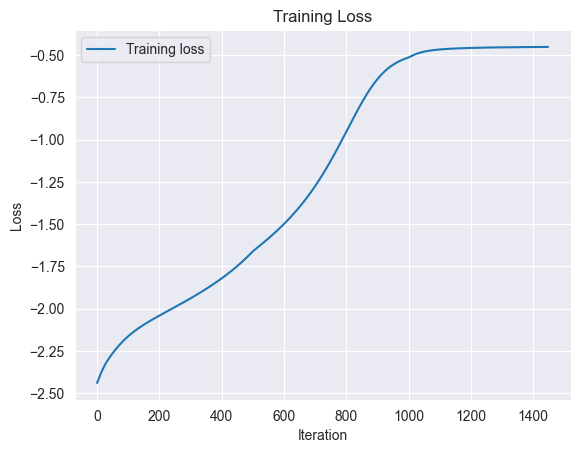

In [316]:
# Plot training loss
plt.title('Training Loss')
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [317]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0056, RMSE = 0.0749, R2 = 0.9762


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [318]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

Target 1: MSE = 0.1650, RMSE = 0.4063, R2 = 0.3748
